# Machine Learning Semester Project
## Murtaza Hussain (29449) and Muhammad Asad ur Rehman (29456)

### Class Imbalance Problem

The below code solves the prevalent problem of imbalanced dataset, where one class dominates the dataset as compared to the other. Such is the case for the following dataset for Credit Card Transactions to detect Fraudulent Transactions. We will evaluate the following methods to resolve Class Imbalance:
1. Random Under Sampling
2. Algorithmic Methods (Using Random Forest as well as modifying Class Weights)
3. Anomaly Detection Method

For the following Dataset, we will use the following 5 Algorithms to draw a comparision between different methods:
1. Logistic Regression
2. K-Nearest Neighbors (KNN)
3. Random Forest
4. Support Vector Machines (SVM)
5. Naive Bayes (Gaussian)

In [1]:
# Import necessary libraries
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Data Loader loads data from CSV Files
def load_dataset():
    dataset = pd.read_csv("./Source.SonarData.csv")
    return dataset

# df = load_dataset()

In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

# null_check(df)

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [5]:
# Prints a summary of class instances and distribution
def data_summary(df, target=None):
    if isinstance(df, pd.DataFrame) and target!=None:
        a = df[target].value_counts()
    else:
        a = df.value_counts()
    class0 = format(100 * a[0]/sum(a), ".2f")
    class1 = format(100 * a[1]/sum(a), ".2f")

    meta = pd.DataFrame([{ "%": class0, "count": a[0]},
                         { "%": class1, "count": a[1]}])
    print("\nClass Distribution:\n", meta, "\n")

# data_summary(df,'target')

In [6]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object', 'int64']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

# df['target'] = df['target'].astype(str)
# df = transform_data(df)

In [7]:
# Runs Baseline Model for All 5 Algorithms
def BaselineRunAll(df, target_name, k=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    print("Class Distribution for Baseline Run:")
    data_summary(y)

    # Initialize the classifiers
    lr_classifier = LogisticRegression(max_iter=1000)
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()
    svm_classifier = SVC()
    nb_classifier = GaussianNB()
    

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)     # The reasoning behind k = 10 is so as to strike a balance between test and train samples of minority class

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), # As the majority class has 99.81% presence, accuracy cannot be used as a metric to evaluate performance
                               'precision': make_scorer(precision_score, pos_label=1)}
    
    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'Baseline',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })

    df = pd.DataFrame(results)
    return df

# results = BaselineRunAll(df, 'target')
# print(results)

In [8]:
# Performs Oversampling of Minority class using SMOTE and tests on all 5 Algorithms
def RandomSamplingSMOTE(df, target_name, k=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Oversample using SMOTE
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    
    print("Class Distribution after Oversampling Minority Class using SMOTE:")
    data_summary(y)

    # Initialize the classifiers
    lr_classifier = LogisticRegression(max_iter=1000)
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()
    svm_classifier = SVC()
    nb_classifier = GaussianNB()

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), 
                               'precision': make_scorer(precision_score, pos_label=1)}

    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'SMOTE',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })
    
    df = pd.DataFrame(results)
    return df

# results = RandomSamplingSMOTE(df, 'target')
# print(results)

In [9]:
# Performs Oversampling of Minority class using ADASYN and tests on all 5 Algorithms
def RandomSamplingADASYN(df, target_name, k=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Oversample using ADASYN
    adasyn = ADASYN(random_state=42)
    X, y = adasyn.fit_resample(X, y)
    
    print("Class Distribution after Oversampling Minority Class using ADASYN:")
    data_summary(y)

    # Initialize the classifiers
    lr_classifier = LogisticRegression(max_iter=1000)
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()
    svm_classifier = SVC()
    nb_classifier = GaussianNB()

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), 
                               'precision': make_scorer(precision_score, pos_label=1)}

    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'ADASYN',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })
    
    df = pd.DataFrame(results)
    return df

# results = RandomSamplingADASYN(df, 'target')
# print(results)

In [10]:
# Plot a Model vs Recall graph for Classification Dataset for Each Method
def plot_model_recall_graph(df):
    plt.figure(figsize=(10, 6))
    
    # Plotting lines for each Method
    sns.lineplot(data=df, x='Classifier', y='Class 1 Recall', hue='Method', marker='o')

    plt.title('Classifier vs Recall')
    plt.xlabel('Classifier')
    plt.ylabel('Recall')
    plt.legend(title='Method')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
# Plot a Model vs Precision graph for Classification Dataset for Each Method
def plot_model_precision_graph(df):
    plt.figure(figsize=(10, 6))
    
    # Plotting lines for each Method
    sns.lineplot(data=df, x='Classifier', y='Class 1 Precision', hue='Method', marker='o')

    plt.title('Classifier vs Precision')
    plt.xlabel('Classifier')
    plt.ylabel('Precision')
    plt.legend(title='Method')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def master_workflow():
    # Load Dataset
    df = load_dataset()
    # No need for Data Cleaning and EDA as Data is already clean
    # Evaluate Class Distribution of the cleaned Dataset
    data_summary(df,'target')
    # Transform and Encode Data
    df['target'] = df['target'].astype(str)
    df = transform_data(df)
    # Run Baseline Models using k = 10
    baseline_results = BaselineRunAll(df, 'target')
    # Evaluate Models using SMOTE Oversampling Technique
    smote_results = RandomSamplingSMOTE(df, 'target')
    # Evaluate Models using ADASYN Oversampling Technique
    adasyn_results = RandomSamplingADASYN(df, 'target')
    # Concatenate the results
    results_df = pd.concat([baseline_results, smote_results, adasyn_results])
    # Print results
    print(results_df)
    results_df.to_csv('Results/SonarData.SamplingMethodsResults.csv', index=False)
    # Plot a Classifier vs Recall Graph -> To evaluate how well the model is performing to detect the fraudulent transactions (minority class)
    plot_model_recall_graph(results_df)
    # Plot a Classifier vs Precision Graph -> To evaluate how precise the model is to detect the minority class (can be used as a secondary metric for evaluation)
    plot_model_precision_graph(results_df)

In [13]:
# As the pipeline was not running in one go, we had to split it into smaller parts
# master_workflow() 

### Broken down pipeline:

In [14]:
# Load Dataset
df = load_dataset()
# No need for Data Cleaning and EDA as Data is already clean
# Evaluate Class Distribution of the cleaned Dataset
data_summary(df,'target')
# Transform and Encode Data
df['target'] = df['target'].astype(str)
df = transform_data(df)


Class Distribution:
        %  count
0  90.09  49930
1   9.91   5492 

Categorical columns: Index(['target'], dtype='object')
Numerical columns: Index(['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
       'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10',
       'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14',
       'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18',
       'Attribute19', 'Attribute20', 'Attribute21', 'Attribute22',
       'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26',
       'Attribute27', 'Attribute28', 'Attribute29', 'Attribute30',
       'Attribute31', 'Attribute32', 'Attribute33', 'Attribute34',
       'Attribute35', 'Attribute36', 'Attribute37', 'Attribute38',
       'Attribute39', 'Attribute40', 'Attribute41', 'Attribute42',
       'Attribute43', 'Attribute44', 'Attribute45', 'Attribute46',
       'Attribute47', 'Attribute48', 'Attribute49', 'Attribute50',
       'Attribute51', 'Attrib

C:\Users\Murtaza.h\AppData\Local\Temp\ipykernel_4828\2871998234.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class0 = format(100 * a[0]/sum(a), ".2f")
C:\Users\Murtaza.h\AppData\Local\Temp\ipykernel_4828\2871998234.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class1 = format(100 * a[1]/sum(a), ".2f")
C:\Users\Murtaza.h\AppData\Local\Temp\ipykernel_4828\2871998234.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  met

In [15]:
# Run Baseline Models using k = 10
baseline_results = BaselineRunAll(df, 'target')

Class Distribution for Baseline Run:

Class Distribution:
        %  count
0   9.91   5492
1  90.09  49930 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


In [16]:
# Evaluate Models using SMOTE Oversampling Technique
smote_results = RandomSamplingSMOTE(df, 'target')

Class Distribution after Oversampling Minority Class using SMOTE:

Class Distribution:
        %  count
0  50.00  49930
1  50.00  49930 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


In [17]:
# Evaluate Models using ADASYN Oversampling Technique
adasyn_results = RandomSamplingADASYN(df, 'target')

Class Distribution after Oversampling Minority Class using ADASYN:

Class Distribution:
        %  count
0  50.00  49930
1  50.00  49930 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


     Method               Classifier  Class 1 Recall  Class 1 Precision
0  Baseline      Logistic Regression          1.0000             0.9966
1  Baseline            Random Forest          1.0000             1.0000
2  Baseline     K-Nearest Neighbours          1.0000             0.9999
3  Baseline  Support Vector Machines          1.0000             1.0000
4  Baseline              Naive Bayes          0.9360             0.9390
0     SMOTE      Logistic Regression          0.9987             0.9992
1     SMOTE            Random Forest          1.0000             1.0000
2     SMOTE     K-Nearest Neighbours          1.0000             1.0000
3     SMOTE  Support Vector Machines          1.0000             1.0000
4     SMOTE              Naive Bayes          0.9136             0.7051
0    ADASYN      Logistic Regression          1.0000             0.9955
1    ADASYN            Random Forest          1.0000             1.0000
2    ADASYN     K-Nearest Neighbours          1.0000            

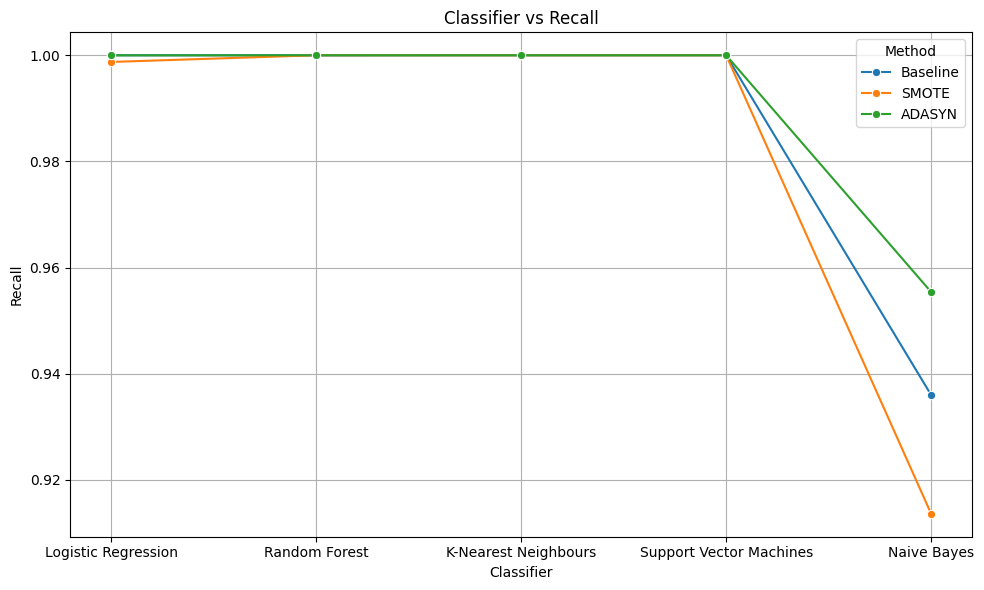

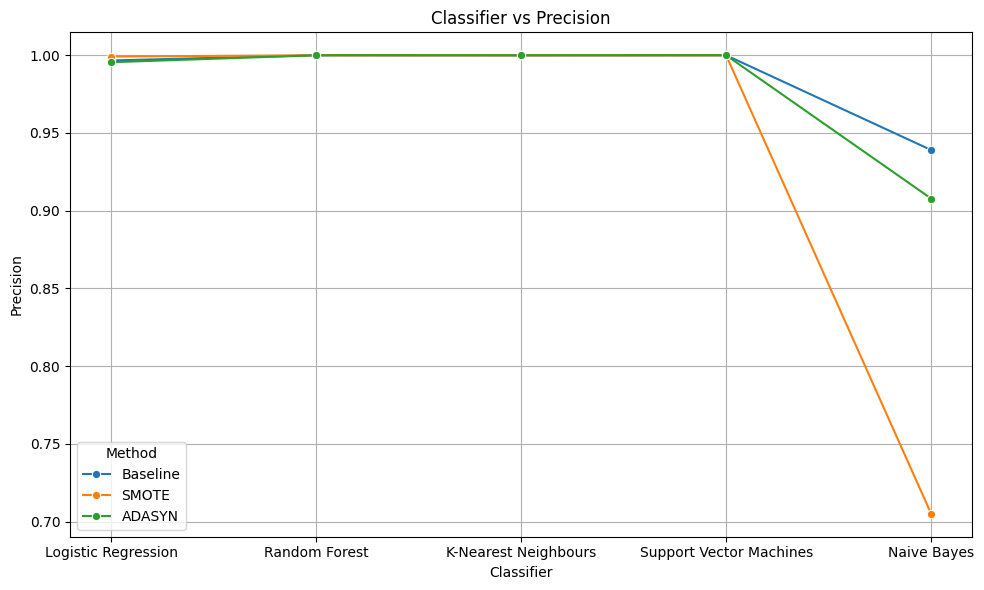

In [18]:
# Concatenate the results
results_df = pd.concat([baseline_results, smote_results, adasyn_results])
# Print results
print(results_df)
results_df.to_csv('Results/SonarData.SamplingMethodsResults.csv', index=False)
# Plot a Classifier vs Recall Graph -> To evaluate how well the model is performing to detect the fraudulent transactions (minority class)
plot_model_recall_graph(results_df)
# Plot a Classifier vs Precision Graph -> To evaluate how precise the model is to detect the minority class (can be used as a secondary metric for evaluation)
plot_model_precision_graph(results_df)